In [6]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
from scipy.stats import zscore

In [7]:
pd

<module 'pandas' from '/home/basti/.local/share/virtualenvs/teastore_experiments-gXtBjM1O/lib/python3.9/site-packages/pandas/__init__.py'>

In [8]:
DATA_DIR = "data"

In [9]:
experiment_dirs = sorted(glob("data/*"))
experiment_dirs

exp_dir = "data/2024-06-20_18-00-12"

In [10]:
measurements = glob(exp_dir + "/*/*/*")
measurements

['data/2024-06-20_18-00-12/exp_scale_rampup/baseline_vanilla_cpu/0',
 'data/2024-06-20_18-00-12/exp_scale_rampup/jvm_jvm-impoove_cpu/0',
 'data/2024-06-20_18-00-12/exp_mem/baseline_vanilla_mem/0',
 'data/2024-06-20_18-00-12/exp_mem/jvm_jvm-impoove_mem/0']

In [11]:
def set_experiment_time(
    df, col="collection_time", target="experiment_time", where="run"
):
    missing_time = df[df[col] == "0"]
    print(f"{len(missing_time)} missing times")
    df.drop(missing_time.index, inplace=True)
    df[col] = pd.to_datetime(df[col])

    # the fancy way with different starting times:
    # df["run_starts"] = df.groupby(where)[col].transform("min")
    # df[target] = df[col] - df["run_starts"]

    # one experiment per df:
    df[target] = df[col] - df[col].min()


def drop_outliers(df, z_score_threshold=3):
    data_errors = 0

    common_keys = [
        "wattage_kepler",
        "wattage_scaph",
        # "wattage"
        "cpu_usage",
        "memory_usage",
        "network_usage",
    ]

    for key in common_keys:
        if key in df:
            df[f"{key}_zscore"] = zscore(df[key])

    for key in common_keys:
        outliers = df[df[f"{key}_zscore"].abs() > z_score_threshold].index
        data_errors += len(outliers)
        df = df.drop(outliers)

    print(f"dropped {data_errors} outliers")
    return data_errors


def measurement_file_to_df(file: str, prefix: str, treat=True):
    # no risk, no fun
    (_, pr_time, pr_scale, pr_branch, pr_run, pr_name) = file.split("/")
    pod_df = pd.read_csv(file)
    pod_df["exp_workload"] = pr_scale
    pod_df["exp_branch"] = pr_branch
    pod_df["exp_run_i"] = pr_run
    pod_df["exp_id"] = pr_name.replace(prefix, "").replace(".csv", "")

    pod_df["run"] = "_".join([pr_branch, pr_scale, pr_run])

    if treat:
        drop_outliers(pod_df)
        set_experiment_time(pod_df)

    return pod_df


def get_df_for_prefix(prefix, measurement_dirs, treat=True):
    pod_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    all_pods = pd.concat([measurement_file_to_df(pf, prefix, treat) for pf in pod_files])
    return all_pods

In [12]:
all_pods = get_df_for_prefix("measurements_pod_", measurements)
# set_experiment_time(all_pods)
# drop_outliers(all_pods)

all_nodes = get_df_for_prefix("measurements_node_", measurements)
# set_experiment_time(all_nodes)
# drop_outliers(all_nodes)

display(all_pods.describe())
display(all_nodes.describe())

all_nodes['experiment_time'].dtype

dropped 17 outliers
0 missing times
dropped 14 outliers
0 missing times
dropped 23 outliers
0 missing times
dropped 9 outliers
0 missing times
dropped 3 outliers
0 missing times
dropped 4 outliers
0 missing times
dropped 12 outliers
0 missing times
dropped 4 outliers
0 missing times


,collection_time,cpu_usage,memory_usage,network_usage,wattage_kepler,wattage_scaph,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
count,1215,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000,1.215000e+03,1.215000e+03,1.215000e+03,1.215000e+03,1.215000e+03,1215
mean,2024-06-20 18:18:56.687242496,0.061648,621.056590,0.020461,203.909547,0.054810,-1.169618e-16,-2.631640e-17,2.924044e-18,-3.508853e-17,-1.169618e-17,0 days 00:04:30.823045267
min,2024-06-20 18:04:20,0.000000,0.000000,0.000000,0.000000,0.000000,-1.241455e+00,-5.518372e-01,-5.962422e-01,-1.549120e+00,-5.498502e-01,0 days 00:00:00
25%,2024-06-20 18:14:44,0.000000,203.657216,0.000000,5.000000,0.000009,-8.843245e-01,-2.978124e-01,-2.744071e-01,-9.471411e-01,-2.064574e-01,0 days 00:01:21
50%,2024-06-20 18:20:04,0.014095,626.241536,0.000454,16.000000,0.001489,-8.257733e-01,-2.944175e-01,-2.627564e-01,1.607390e-02,-2.064574e-01,0 days 00:02:51
75%,2024-06-20 18:24:58,0.041962,989.556736,0.001496,408.800000,0.044982,1.095292e+00,3.170689e-02,-3.309957e-02,5.808354e-01,-5.770456e-02,0 days 00:07:45
max,2024-06-20 18:29:41,1.499670,2110.824448,0.847959,1063.900000,2.181646,2.783027e+00,1.340856e+01,1.148354e+01,2.883176e+00,1.621370e+01,0 days 00:12:28
std,NaN,0.174621,476.260294,0.089184,223.799323,0.185762,1.000412e+00,1.000412e+00,1.000412e+00,1.000412e+00,1.000412e+00,0 days 00:03:47.540627570


,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,wattage_auxilary,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
count,736,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,7.360000e+02,7.360000e+02,7.360000e+02,7.360000e+02,7.360000e+02,736
mean,2024-06-20 18:18:07.290760960,0.306700,0.174413,0.435617,15.436141,10.820652,0.566268,5.468335,0.040654,5.551115e-17,-5.430439e-17,-1.448117e-17,2.413528e-16,-4.947733e-17,0 days 00:04:16.073369565
min,2024-06-20 18:04:20,0.034000,0.090633,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,-7.761375e-01,-7.109427e-01,-6.908064e-01,-1.711233e+00,-1.095840e+00,0 days 00:00:00
25%,2024-06-20 18:10:01,0.048000,0.128227,0.022081,0.000000,5.000000,0.000000,0.000000,0.000000,-4.808287e-01,-7.042486e-01,-5.959312e-01,-1.032129e+00,-8.441371e-01,0 days 00:01:11
50%,2024-06-20 18:19:24,0.219667,0.189481,0.434324,0.000000,10.000000,0.030067,0.000000,0.000000,-4.808287e-01,-6.892588e-01,-1.167665e-01,1.607572e-01,-3.202498e-01,0 days 00:02:31
75%,2024-06-20 18:24:29.500000,0.289000,0.224103,0.506186,44.000000,16.000000,0.487558,15.188413,0.047835,-5.161142e-02,1.279294e+00,1.233342e-01,9.107882e-01,6.327672e-01,0 days 00:07:16.500000
max,2024-06-20 18:29:41,3.373992,0.264816,4.095389,74.000000,18.000000,8.506733,27.129056,0.359255,6.978340e+00,2.542371e+00,9.756281e+00,1.732904e+00,8.019370e+00,0 days 00:12:28
std,NaN,0.459858,0.052936,0.557131,21.976085,4.877036,1.039495,7.809547,0.070091,1.000680e+00,1.000680e+00,1.000680e+00,1.000680e+00,1.000680e+00,0 days 00:03:45.163783285


dtype('<m8[ns]')

In [13]:
stats = get_df_for_prefix("teastore_stats.csv", measurements, treat=False)
stats

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,run
0,POST,/cartAction | add to cart,11,0,3.00000,3.252388,2.610673,5.406610,0.000000,0.069484,...,5,5,5,5,5,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
1,POST,/cartAction | pay,1,0,2.51527,2.515270,2.515270,2.515270,0.000000,0.006317,...,3,3,3,3,3,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
2,GET,/category,534,31,25.00000,761.658040,3.840590,13562.969288,109211.794007,3.373125,...,10000,11000,14000,14000,14000,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
3,GET,/product,130,0,35.00000,160.986577,23.833584,10257.054898,115190.453846,0.821173,...,1300,1400,10000,10000,10000,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
4,GET,/tools.descartes.teastore.webui,3,0,15.00000,468.758344,11.343856,1379.961845,8905.000000,0.018950,...,1400,1400,1400,1400,1400,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
5,GET,/tools.descartes.teastore.webui/cart,11,0,21.00000,207.576327,13.485168,1333.119455,9579.000000,0.069484,...,1300,1300,1300,1300,1300,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
6,GET,/tools.descartes.teastore.webui/order,1,0,742.03641,742.036410,742.036410,742.036410,8905.000000,0.006317,...,740,740,740,740,740,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
7,NaN,Aggregated,691,31,27.00000,625.359755,2.515270,13562.969288,106273.293777,4.364849,...,10000,11000,14000,14000,14000,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
0,GET,/category,60,50,77.00000,494.442678,30.622196,2733.552570,8257.450000,3.889604,...,2400,2700,2700,2700,2700,exp_scale_rampup,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_rampup_0
1,GET,/product,14,10,160.00000,873.617757,78.479766,2322.742710,6298.214286,0.907574,...,2300,2300,2300,2300,2300,exp_scale_rampup,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_rampup_0


In [14]:
agg_stats = stats[stats['Name'] == "Aggregated"]
agg_stats

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,run
7,NaN,Aggregated,691,31,27.0,625.359755,2.515270,13562.969288,106273.293777,4.364849,...,10000,11000,14000,14000,14000,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
2,NaN,Aggregated,74,60,86.0,566.178504,30.622196,2733.552570,7886.783784,4.797178,...,2400,2700,2700,2700,2700,exp_scale_rampup,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_rampup_0
7,NaN,Aggregated,839,1,24.0,95.788986,2.448045,6676.795608,64352.109654,5.310362,...,670,2800,6700,6700,6700,exp_mem,jvm_jvm-impoove_mem,0,,jvm_jvm-impoove_mem_exp_mem_0


In [15]:
# all_nodes.join(agg_stats, on="run", how="right")
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_branch,exp_run_i,exp_id,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
0,sm-gpu,2024-06-20 18:13:53,2024-06-20 18:13:53,1.275667,0.101960,3.304774,46,13,2.349767,25.866432,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,1.770705,2.237108,0.911071,-1.295390,2.378261,0 days 00:00:00
1,ise-knode2,2024-06-20 18:13:53,2024-06-20 18:13:53,0.048667,0.206151,0.009833,0,5,0.000000,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.776137,-0.701589,-0.671885,0.450335,-1.085504,0 days 00:00:00
2,ise-knode3,2024-06-20 18:13:53,2024-06-20 18:13:53,0.052000,0.128157,0.048896,0,5,0.000000,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.776137,-0.701589,-0.667585,-0.856455,-1.044439,0 days 00:00:00
3,ise-knode6,2024-06-20 18:13:53,2024-06-20 18:13:53,0.245025,0.093945,0.737788,44,17,2.455233,15.744930,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,1.885018,1.087200,-0.418563,-1.429680,-0.320250,0 days 00:00:00
4,ise-kmaster,2024-06-20 18:13:53,2024-06-20 18:13:53,0.387667,0.244042,1.002343,0,10,0.000000,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.776137,-0.701589,-0.234540,1.085193,-0.042141,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,ise-knode2,2024-06-20 18:10:11,2024-06-20 18:10:11,0.047333,0.199498,0.167271,0,4,0.000000,0.000000,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,-0.706119,-0.710943,-0.665193,0.880124,-0.605574,0 days 00:02:32
92,ise-knode3,2024-06-20 18:10:11,2024-06-20 18:10:11,0.037667,0.128623,0.016164,0,5,0.000000,0.000000,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,-0.706119,-0.710943,-0.685498,-0.583994,-0.851234,0 days 00:02:32
93,ise-knode6,2024-06-20 18:10:11,2024-06-20 18:10:11,0.204333,0.094190,0.489207,44,17,1.992300,15.138345,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,1.906370,1.226510,-0.335423,-1.295310,-0.082192,0 days 00:02:32
94,ise-kmaster,2024-06-20 18:10:11,2024-06-20 18:10:11,0.265333,0.239132,0.436071,0,10,0.000000,0.000000,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,-0.706119,-0.710943,-0.207295,1.698892,-0.168578,0 days 00:02:32


In [16]:
all_pods.groupby(all_pods['name'])[['cpu_usage', 'memory_usage', 'wattage_kepler', 'wattage_scaph']].describe(percentiles=[])

cpu_usage                                               \
                           count      mean       std  min       50%       max   
name                                                                            
loadgenerator              120.0  0.005885  0.010266  0.0  0.000731  0.039003   
teastore-auth-0            122.0  0.074101  0.138598  0.0  0.028067  0.676322   
teastore-auth-1             69.0  0.043842  0.127773  0.0  0.000000  0.628263   
teastore-db-0              122.0  0.012412  0.048519  0.0  0.001431  0.338701   
teastore-image-0           123.0  0.114871  0.292123  0.0  0.029403  1.499670   
teastore-image-1            36.0  0.021701  0.069687  0.0  0.000000  0.287965   
teastore-persistence-0     122.0  0.066661  0.125387  0.0  0.019237  0.654475   
teastore-recommender-0     122.0  0.073202  0.155675  0.0  0.032845  0.799596   
teastore-recommender-1      57.0  0.046905  0.094932  0.0  0.026306  0.523364   
teastore-recommender-2      39.0  0.120653  0.296962  0.0  0.036086  1.132132   
teastore-registry-0        123.0  0.014660  0.013470  0.0  0.013963  0.066108   
teastore-webui-0           123.0  0.147308  0.300263  0.0  0.032941  1.489760   
teastore-webui-1            37.0  0.036273  0.119288  0.0  0.000000  0.501840   

                       memory_usage                                       ...  \
                              count         mean         std         min  ...   
name                                                                      ...   
loadgenerator                 120.0    40.631040    5.186679   21.454848  ...   
teastore-auth-0               122.0   703.515682  324.576852    5.492736  ...   
teastore-auth-1                69.0   641.373229  192.590470    0.000000  ...   
teastore-db-0                 122.0    96.755108   11.930341    5.275648  ...   
teastore-image-0              123.0   850.978233  605.595723    3.174400  ...   
teastore-image-1               36.0   930.223559  229.396141    0.000000  ...   
teastore-persistence-0        122.0   576.830061  150.366798    3.211264  ...   
teastore-recommender-0        122.0   800.413814  213.387953    3.170304  ...   
teastore-recommender-1         57.0   881.979536  250.400569    3.190784  ...   
teastore-recommender-2         39.0   811.460871  247.269367    7.749632  ...   
teastore-registry-0           123.0   257.945117   35.705610  194.285568  ...   
teastore-webui-0              123.0  1100.925228  478.760057    5.271552  ...   
teastore-webui-1               37.0  1421.007014  495.773398    0.000000  ...   

                       wattage_kepler                     wattage_scaph  \
                                  std  min    50%     max         count   
name                                                                      
loadgenerator                0.000000  0.0    0.0     0.0         120.0   
teastore-auth-0            208.178398  0.0   10.6   664.8         122.0   
teastore-auth-1            211.673479  0.0  376.4   612.6          69.0   
teastore-db-0              214.631375  0.0    5.4  1063.9         122.0   
teastore-image-0           155.889264  0.0   10.6   664.8         123.0   
teastore-image-1           213.408451  0.0    0.0   612.6          36.0   
teastore-persistence-0      95.191895  0.0  421.2   664.8         122.0   
teastore-recommender-0     206.017537  0.0   10.6   612.6         122.0   
teastore-recommender-1     103.296126  0.0  398.0   421.8          57.0   
teastore-recommender-2     112.537482  0.0  366.0   370.4          39.0   
teastore-registry-0         94.924571  0.0  420.6   664.8         123.0   
teastore-webui-0           194.833839  0.0  395.6   664.8         123.0   
teastore-webui-1           211.200539  0.0    0.0   612.6          37.0   

                                                                     
                            mean       std  min       50%       max  
name                                                                 
loadgenerator     

<Axes: xlabel='experiment_time', ylabel='wattage_scaph'>

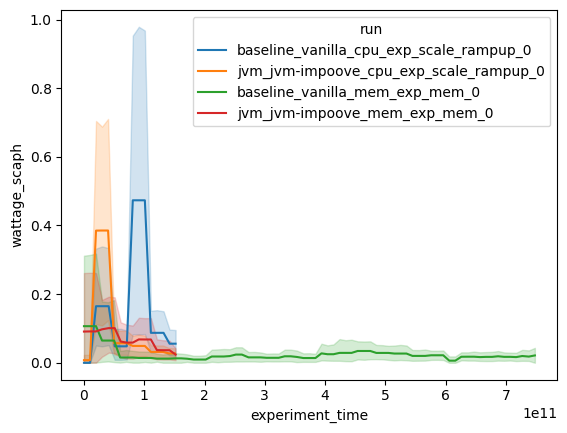

In [17]:
sns.lineplot(data=all_pods, x="experiment_time", y="wattage_scaph", hue="run")

In [18]:
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_branch,exp_run_i,exp_id,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
0,sm-gpu,2024-06-20 18:13:53,2024-06-20 18:13:53,1.275667,0.101960,3.304774,46,13,2.349767,25.866432,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,1.770705,2.237108,0.911071,-1.295390,2.378261,0 days 00:00:00
1,ise-knode2,2024-06-20 18:13:53,2024-06-20 18:13:53,0.048667,0.206151,0.009833,0,5,0.000000,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.776137,-0.701589,-0.671885,0.450335,-1.085504,0 days 00:00:00
2,ise-knode3,2024-06-20 18:13:53,2024-06-20 18:13:53,0.052000,0.128157,0.048896,0,5,0.000000,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.776137,-0.701589,-0.667585,-0.856455,-1.044439,0 days 00:00:00
3,ise-knode6,2024-06-20 18:13:53,2024-06-20 18:13:53,0.245025,0.093945,0.737788,44,17,2.455233,15.744930,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,1.885018,1.087200,-0.418563,-1.429680,-0.320250,0 days 00:00:00
4,ise-kmaster,2024-06-20 18:13:53,2024-06-20 18:13:53,0.387667,0.244042,1.002343,0,10,0.000000,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.776137,-0.701589,-0.234540,1.085193,-0.042141,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,ise-knode2,2024-06-20 18:10:11,2024-06-20 18:10:11,0.047333,0.199498,0.167271,0,4,0.000000,0.000000,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,-0.706119,-0.710943,-0.665193,0.880124,-0.605574,0 days 00:02:32
92,ise-knode3,2024-06-20 18:10:11,2024-06-20 18:10:11,0.037667,0.128623,0.016164,0,5,0.000000,0.000000,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,-0.706119,-0.710943,-0.685498,-0.583994,-0.851234,0 days 00:02:32
93,ise-knode6,2024-06-20 18:10:11,2024-06-20 18:10:11,0.204333,0.094190,0.489207,44,17,1.992300,15.138345,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,1.906370,1.226510,-0.335423,-1.295310,-0.082192,0 days 00:02:32
94,ise-kmaster,2024-06-20 18:10:11,2024-06-20 18:10:11,0.265333,0.239132,0.436071,0,10,0.000000,0.000000,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,-0.706119,-0.710943,-0.207295,1.698892,-0.168578,0 days 00:02:32


In [19]:
all_nodes.groupby(['exp_workload', 'exp_branch', 'run']).describe()

collection_time  \
                                                                                        count   
exp_workload     exp_branch           run                                                       
exp_mem          baseline_vanilla_mem baseline_vanilla_mem_exp_mem_0                      448   
                 jvm_jvm-impoove_mem  jvm_jvm-impoove_mem_exp_mem_0                        96   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0              96   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_rampup_0               96   

                                                                                                              \
                                                                                                        mean   
exp_workload     exp_branch           run                                                                      
exp_mem          baseline_vanilla_mem baseline_vanilla_mem_exp_mem_0           2024-06-20 18:23:24.955357184   
                 jvm_jvm-impoove_mem  jvm_jvm-impoove_mem_exp_mem_0            2024-06-20 18:08:54.875000064   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-20 18:15:08.937499904   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_rampup_0   2024-06-20 18:05:35.625000192   

                                                                                                    \
                                                                                               min   
exp_workload     exp_branch           run                                                            
exp_mem          baseline_vanilla_mem baseline_vanilla_mem_exp_mem_0           2024-06-20 18:17:13   
                 jvm_jvm-impoove_mem  jvm_jvm-impoove_mem_exp_mem_0            2024-06-20 18:07:39   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-20 18:13:53   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_rampup_0   2024-06-20 18:04:20   

                                                                                                              \
                                                                                                         25%   
exp_workload     exp_branch           run                                                                      
exp_mem          baseline_vanilla_mem baseline_vanilla_mem_exp_mem_0                     2024-06-20 18:20:15   
                 jvm_jvm-impoove_mem  jvm_jvm-impoove_mem_exp_mem_0            2024-06-20 18:08:17.249999872   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-20 18:14:31.249999872   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_rampup_0      2024-06-20 18:04:57.500000   

                                                                                                    \
                                                                                               50%   
exp_workload     exp_branch           run                                                            
exp_mem          baseline_vanilla_mem baseline_vanilla_mem_exp_mem_0           2024-06-20 18:23:27   
                 jvm_jvm-impoove_mem  jvm_jvm-impoove_mem_exp_mem_0            2024-06-20 18:08:55   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-20 18:15:09   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_rampup_0   2024-06-20 18:05:36   

                                                                                                           \
                                                                                                      75%   
exp_workload     exp_branch           run                                                                   
exp_mem          baseline_vanilla_mem baseline_vanilla_mem_exp_mem_0   

<Axes: xlabel='experiment_time', ylabel='cpu_usage'>

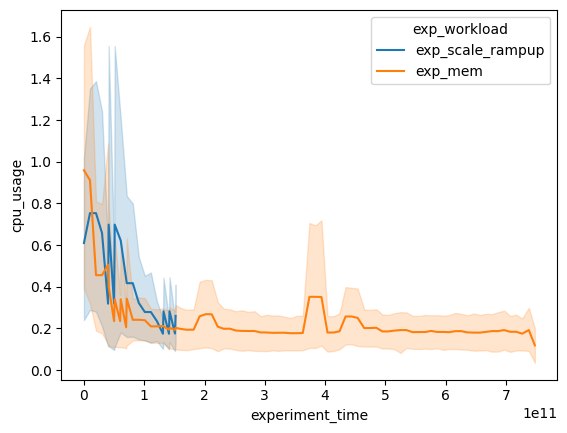

In [20]:
sns.lineplot(data=all_nodes, x="experiment_time", y="cpu_usage", hue="exp_workload")

<Axes: xlabel='experiment_time', ylabel='memory_usage'>

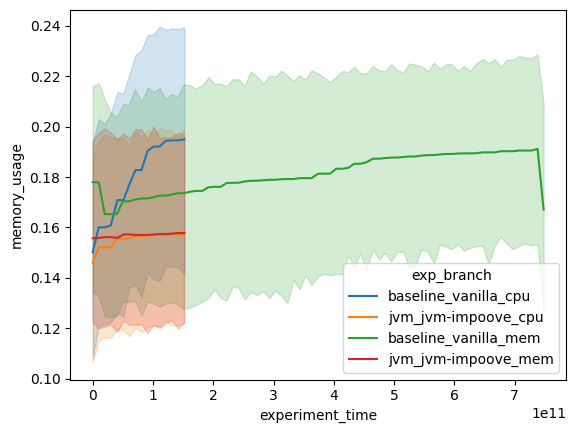

In [21]:
sns.lineplot(data=all_nodes, x="experiment_time", y="memory_usage", hue="exp_branch")

<Axes: xlabel='experiment_time', ylabel='memory_usage'>

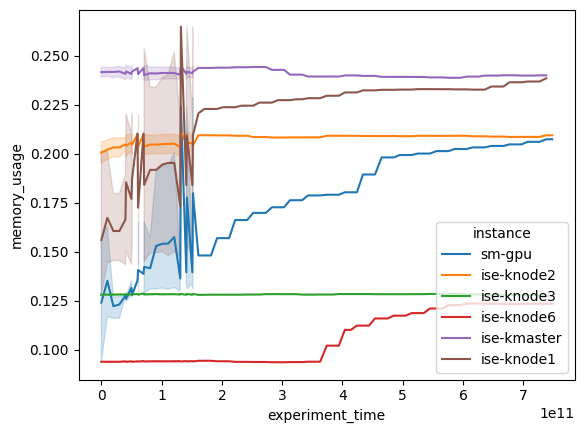

In [22]:
sns.lineplot(data=all_nodes, x="experiment_time", y="memory_usage", hue="instance")

In [23]:
wattage_fields = ["wattage", "wattage_kepler", "wattage_scaph", "wattage_auxilary"]
wattage_df = pd.melt(frame=all_nodes, id_vars=("exp_workload", "exp_branch", "experiment_time"), value_vars=wattage_fields)

display(wattage_df)
# sns.pairplot(data=wattage_df, x="experiment_time", y="value", hue="variable")


,exp_workload,exp_branch,experiment_time,variable,value
0,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:00:00,wattage,46.000000
1,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:00:00,wattage,0.000000
2,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:00:00,wattage,0.000000
3,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:00:00,wattage,44.000000
4,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:00:00,wattage,0.000000
...,...,...,...,...,...
2939,exp_mem,jvm_jvm-impoove_mem,0 days 00:02:32,wattage_auxilary,0.000000
2940,exp_mem,jvm_jvm-impoove_mem,0 days 00:02:32,wattage_auxilary,0.000000
2941,exp_mem,jvm_jvm-impoove_mem,0 days 00:02:32,wattage_auxilary,0.172635
2942,exp_mem,jvm_jvm-impoove_mem,0 days 00:02:32,wattage_auxilary,0.000000


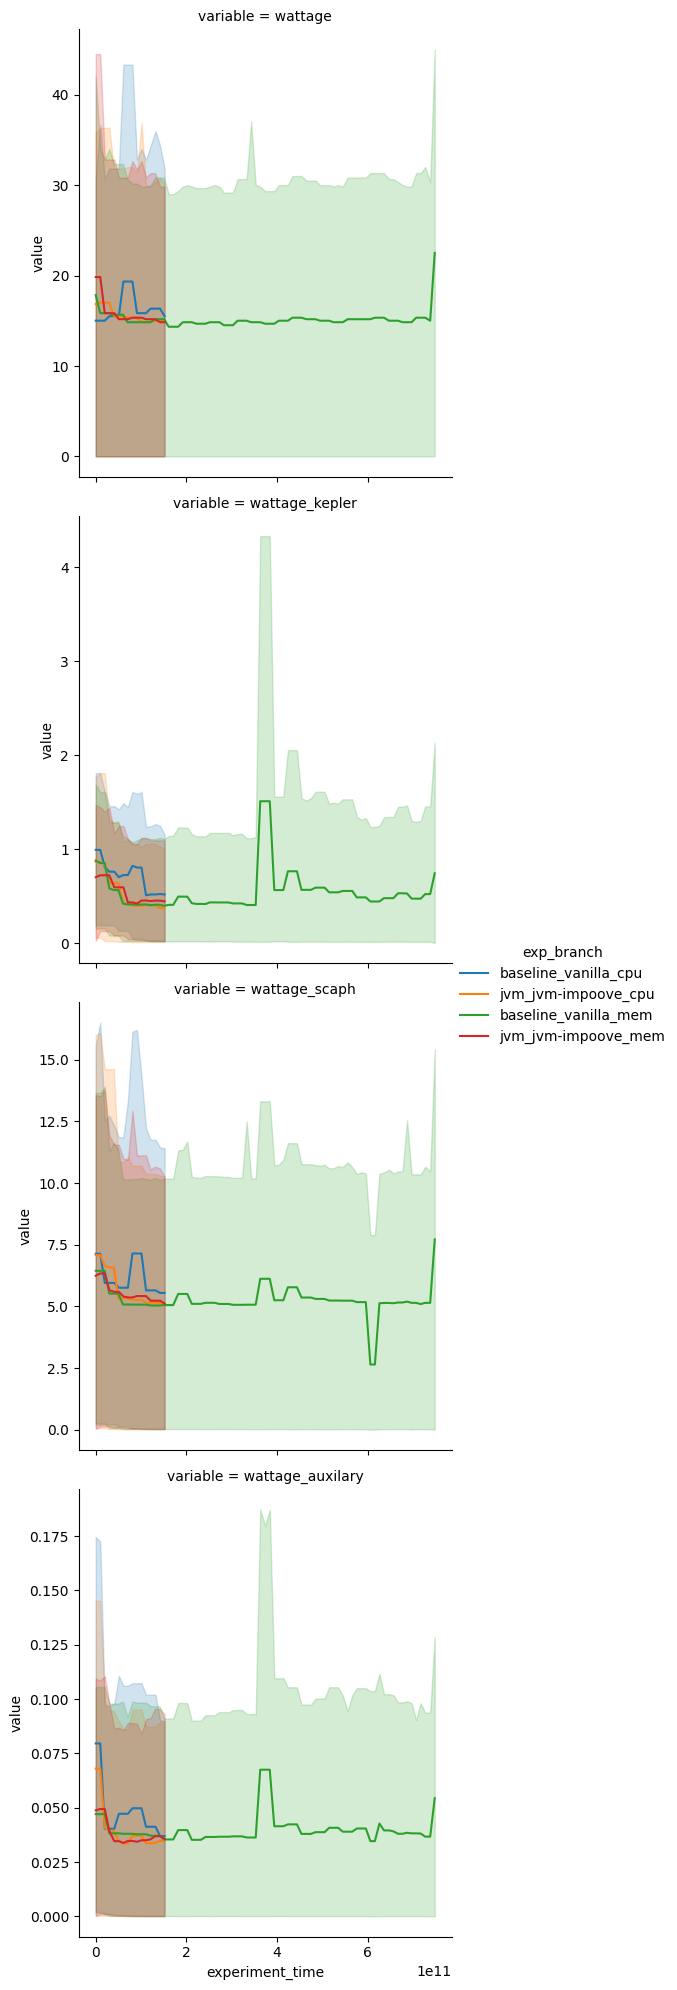

In [24]:
sns.relplot(
    data=wattage_df,
    kind="line",
    x="experiment_time",
    y="value",
    row="variable",
    # row="exp_workload",
    hue="exp_branch",
    facet_kws=dict(sharey=False),
)

In [25]:
all_nodes.dtypes

instance                          object
observation_time                  object
collection_time           datetime64[ns]
cpu_usage                        float64
memory_usage                     float64
network_usage                    float64
wattage                            int64
num_processes                      int64
wattage_kepler                   float64
wattage_scaph                    float64
wattage_auxilary                 float64
exp_workload                      object
exp_branch                        object
exp_run_i                         object
exp_id                            object
run                               object
wattage_kepler_zscore            float64
wattage_scaph_zscore             float64
cpu_usage_zscore                 float64
memory_usage_zscore              float64
network_usage_zscore             float64
experiment_time          timedelta64[ns]
dtype: object

In [26]:
# meaningful aggregations

display(all_pods)
display(agg_stats)
pod_stats = all_pods.groupby(["run"])[["wattage_scaph","wattage_kepler","cpu_usage"]].mean()
pod_stats


,collection_time,observation_time,name,namespace,cpu_usage,memory_usage,network_usage,instance,wattage_kepler,wattage_scaph,...,exp_branch,exp_run_i,exp_id,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
0,2024-06-20 18:13:53,2024-06-20 18:13:53,teastore-registry-0,tea-bench,0.000000,229.597184,0.000000,unknown,0.0,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.969610,-0.400595,-0.472353,-0.571335,-0.463265,0 days 00:00:00
1,2024-06-20 18:13:53,2024-06-20 18:13:53,teastore-webui-0,tea-bench,0.000000,208.672768,0.000000,unknown,0.0,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.969610,-0.400595,-0.472353,-0.609759,-0.463265,0 days 00:00:00
2,2024-06-20 18:13:53,2024-06-20 18:13:53,teastore-image-0,tea-bench,0.000000,5.459968,0.000000,unknown,0.0,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.969610,-0.400595,-0.472353,-0.982920,-0.463265,0 days 00:00:00
3,2024-06-20 18:13:53,2024-06-20 18:13:53,loadgenerator,tea-bench,0.000000,41.193472,0.000000,unknown,0.0,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.969610,-0.400595,-0.472353,-0.917302,-0.463265,0 days 00:00:00
4,2024-06-20 18:13:53,2024-06-20 18:13:53,teastore-auth-0,tea-bench,0.000000,273.657856,0.000000,unknown,0.0,0.000000,...,baseline_vanilla_cpu,0,20_06_2024_18_13,baseline_vanilla_cpu_exp_scale_rampup_0,-0.969610,-0.400595,-0.472353,-0.490426,-0.463265,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2024-06-20 18:10:11,2024-06-20 18:10:11,loadgenerator,tea-bench,0.013826,40.863744,0.064514,unknown,0.0,0.000000,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,-0.884324,-0.551837,-0.499508,-1.198946,-0.027455,0 days 00:02:32
124,2024-06-20 18:10:11,2024-06-20 18:10:11,teastore-db-0,tea-bench,0.002806,98.836480,0.010883,ise-knode1,5.4,0.000026,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,-0.863520,-0.551623,-0.576608,-0.959490,-0.461728,0 days 00:02:32
125,2024-06-20 18:10:11,2024-06-20 18:10:11,teastore-auth-0,tea-bench,0.053604,274.464768,0.005092,sm-gpu,496.4,0.055596,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,1.028111,-0.101614,-0.221204,-0.234061,-0.508618,0 days 00:02:32
126,2024-06-20 18:10:11,2024-06-20 18:10:11,teastore-recommender-0,tea-bench,0.034174,861.368320,0.001495,sm-gpu,496.4,0.055596,...,jvm_jvm-impoove_mem,0,20_06_2024_18_07,jvm_jvm-impoove_mem_exp_mem_0,1.028111,-0.101614,-0.357144,2.190132,-0.537742,0 days 00:02:32


,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,run
7,NaN,Aggregated,691,31,27.0,625.359755,2.515270,13562.969288,106273.293777,4.364849,...,10000,11000,14000,14000,14000,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
2,NaN,Aggregated,74,60,86.0,566.178504,30.622196,2733.552570,7886.783784,4.797178,...,2400,2700,2700,2700,2700,exp_scale_rampup,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_rampup_0
7,NaN,Aggregated,839,1,24.0,95.788986,2.448045,6676.795608,64352.109654,5.310362,...,670,2800,6700,6700,6700,exp_mem,jvm_jvm-impoove_mem,0,,jvm_jvm-impoove_mem_exp_mem_0


,wattage_scaph,wattage_kepler,cpu_usage
run,,,
baseline_vanilla_cpu_exp_scale_rampup_0,0.156895,238.318634,0.149037
baseline_vanilla_mem_exp_mem_0,0.024391,173.310250,0.034999
jvm_jvm-impoove_cpu_exp_scale_rampup_0,0.103960,328.187302,0.095237
jvm_jvm-impoove_mem_exp_mem_0,0.068143,229.539062,0.085221


In [27]:
merged_stats = pd.merge(left=pod_stats, right=agg_stats, on="run")
merged_stats

,run,wattage_scaph,wattage_kepler,cpu_usage,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,...,95%,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id
0,baseline_vanilla_cpu_exp_scale_rampup_0,0.156895,238.318634,0.149037,NaN,Aggregated,691,31,27.0,625.359755,...,5500,10000,11000,14000,14000,14000,exp_scale_rampup,baseline_vanilla_cpu,0,
1,jvm_jvm-impoove_cpu_exp_scale_rampup_0,0.103960,328.187302,0.095237,NaN,Aggregated,74,60,86.0,566.178504,...,2300,2400,2700,2700,2700,2700,exp_scale_rampup,jvm_jvm-impoove_cpu,0,
2,jvm_jvm-impoove_mem_exp_mem_0,0.068143,229.539062,0.085221,NaN,Aggregated,839,1,24.0,95.788986,...,61,670,2800,6700,6700,6700,exp_mem,jvm_jvm-impoove_mem,0,


In [28]:
merged_stats['scaph_per_rq'] = merged_stats['wattage_scaph'] / merged_stats['Request Count']
merged_stats['kepler_per_rq'] = merged_stats['wattage_kepler'] / merged_stats['Request Count']

merged_stats

,run,wattage_scaph,wattage_kepler,cpu_usage,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,...,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,scaph_per_rq,kepler_per_rq
0,baseline_vanilla_cpu_exp_scale_rampup_0,0.156895,238.318634,0.149037,NaN,Aggregated,691,31,27.0,625.359755,...,11000,14000,14000,14000,exp_scale_rampup,baseline_vanilla_cpu,0,,0.000227,0.344889
1,jvm_jvm-impoove_cpu_exp_scale_rampup_0,0.103960,328.187302,0.095237,NaN,Aggregated,74,60,86.0,566.178504,...,2700,2700,2700,2700,exp_scale_rampup,jvm_jvm-impoove_cpu,0,,0.001405,4.434964
2,jvm_jvm-impoove_mem_exp_mem_0,0.068143,229.539062,0.085221,NaN,Aggregated,839,1,24.0,95.788986,...,2800,6700,6700,6700,exp_mem,jvm_jvm-impoove_mem,0,,0.000081,0.273586


<Axes: xlabel='value', ylabel='run'>

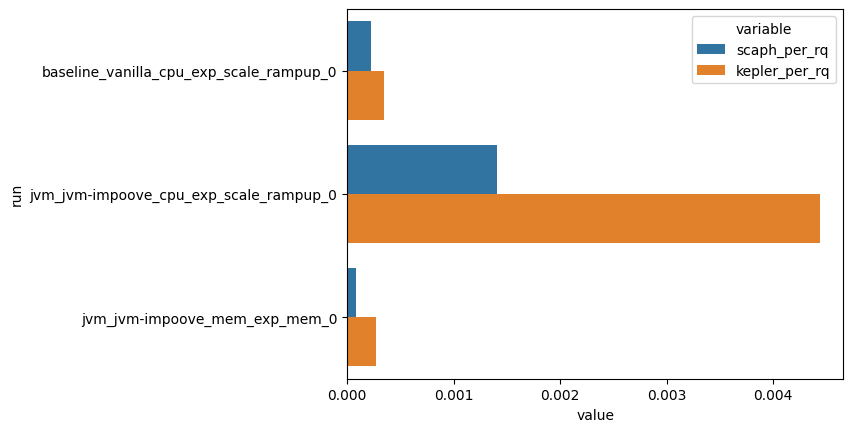

In [36]:
from matplotlib import pyplot as plt

merged_scaled = merged_stats.copy()
merged_scaled['kepler_per_rq'] /= 1_000 
melted = pd.melt(frame=merged_scaled, id_vars="run", value_vars=["scaph_per_rq", "kepler_per_rq"])
sns.barplot(data=melted, y="run", x="value", hue="variable")



In [38]:
merged_stats['scaph_per_rq'].mean() / merged_stats['kepler_per_rq'].mean()

merged_stats[['scaph_per_rq', 'kepler_per_rq']].corr()

,scaph_per_rq,kepler_per_rq
scaph_per_rq,1.000000,0.996332
kepler_per_rq,0.996332,1.000000
